In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import math

<h1> Prepare the data

Download the dataset from the one of the following links:
- https://www.nist.gov/itl/iad/image-group/emnist-dataset
- https://www.kaggle.com/crawford/emnist

# MNIST Balanced dataset
- Includes digits 0-9 and alphabet A-Za-z (where lower-case letters that are similar to upper-case letters are ommitted due to mis-classification)
- Each digit and letters have equal number of samples
- label is in the first column of loaded dataset and is corresponds to the order <br>
    eg. letter A is labeled as 10 etc...

![title](dataset_info.png)

![title](dataset_info2.png)

In [2]:
# Load the data
letters_train_path = 'data/emnist-balanced-train.csv'
letters_test_path = 'data/emnist-balanced-test.csv'

In [3]:
train_data = pd.read_csv(letters_train_path, header=None)
test_data = pd.read_csv(letters_test_path, header=None)

In [4]:
# change from panda dataframe to numpy array 
data_train = train_data.values
data_test = test_data.values

In [5]:
data_train.shape, data_test.shape

((112800, 785), (18800, 785))

train: 112,800 <br>
test: 18,800 <br>
total: 131,600 <br>
classes: 47 (from 0-9A-Za-z but 15 lower-alphabets are missing since they are omitted to avoid mis-classification errors) <br>
image size: 28 by 28 (784) 

<h1> Data Processing


- Separate y value (which in first column)
- One-Hot encode y

In [6]:
# notice train_data is panda frame and data_train is numpy array 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112800 entries, 0 to 112799
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 675.6 MB


In [7]:
# Change the datatype and separate the y values
x_train = data_train[:, 1:]
y_train = data_train[:, 0:1]

x_test = data_test[:, 1:]
y_test = data_test[:, 0:1]

## One-hot encoding
Turn y values to one hot encoding of [examples *47]
- notice: y_train, y_test is a column vector. Function requires row vector to create a One-hot encoding 
- https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
- https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array

In [8]:
def hot_encoder(data):
    data = data.reshape(-1) # turn to row vector 
    hot_encoded = np.zeros((data.size,data.max()+1)) # create 0's of [ n * num_classes ]
    hot_encoded[np.arange(data.size), data] = 1

    return hot_encoded
    
y_train_hot = hot_encoder(y_train)
y_test_hot = hot_encoder(y_test)


In [9]:
y_train_hot.shape, y_test_hot.shape

((112800, 47), (18800, 47))

In [10]:
# check to see one sample
y_test_hot[3],y_test[3]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([26]))

In [11]:
# change the data type from int to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')

## Configuration
some configuration for later use:

In [12]:
# The number of pixels in each dimension of an image.
img_size = 28

# The images are stored in one-dimensional arrays of this length.
img_size_flat = x_train.shape[1] # 28 * 28 = 784

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size,img_size)

# Number of classes, one class for each of characters.
num_classes = 47 

num_channels = 1

## Rotation
for some reason, the image is flipped and rotated, thus we need to fix 

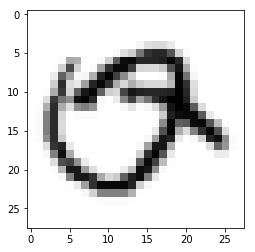

In [13]:
# try display one letter 
plt.imshow(x_test[3].reshape([28, 28]), cmap='binary')
plt.show()

In [14]:
def rotate(image):
    image = image.reshape(img_shape) # put back shape to 28 by 28
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape(img_size * img_size)

# since it is a gray scale image 
# applying per row 
x_train = np.apply_along_axis(rotate, 1, x_train)
x_test = np.apply_along_axis(rotate, 1, x_test)

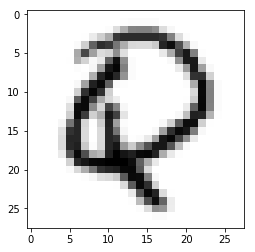

In [15]:
plt.imshow(x_test[3].reshape(img_shape), cmap='binary')
plt.show()

Let's plot some more

In [16]:
# displays 9 images from the dataset 
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

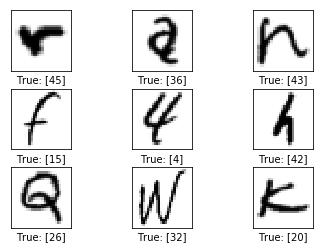

In [17]:
# Get the first 9 images from the train-set.
images = x_train[0:9]

# Get the true classes for those images.
cls_true =y_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Normalization
- Since its image, max pixel is 255 thus we can just devide by 255 to get its range in [0,1]. 

In [18]:
x_train[0].max(),x_train[0].min()

(255.0, 0.0)

In [19]:
x_train_norm = x_train/255.
x_test_norm = x_test/255.
x_train_norm[0].max(),x_train_norm[0].min()

(1.0, 0.0)

## Split to Train, Test, Validation set 

In [20]:
# we don't need to shuffle the data since data is not sorted 
# we will take 20 % of data from 112800 samples in train set
num_valid = int(x_train_norm.shape[0] * 0.2)

x_train = x_train_norm[num_valid:]
y_train_hot = y_train_hot[num_valid:,:]

x_valid = x_train_norm[:num_valid]
y_valid_hot = y_train_hot[:num_valid,:]

In [21]:
x_train.shape, x_valid.shape, x_test.shape

((90240, 784), (22560, 784), (18800, 784))

In [22]:
y_train_hot.shape, y_valid_hot.shape, y_test_hot.shape

((90240, 47), (22560, 47), (18800, 47))

In [23]:
y_train_hot = y_train_hot.astype('float32') 
y_valid_hot = y_valid_hot.astype('float32') 
y_test_hot = y_test_hot.astype('float32') 

## Future to do 
- Data Augmentation (shift, rotate, rescale) for getting more data to get higher accuracy
- https://github.com/ChaitanyaBaweja/RotNIST/blob/master/main.py

# Model architecture 

2 Conv layer followed like:

Conv -> activation -> max pooling -> Conv -> activation -> max pooling -> Flatten -> FCN -> FCN 

train on K-fold using scikit learn 
https://www.kaggle.com/wenyangsama/kfold-cnn-maxpooling
https://chrisalbon.com/deep_learning/keras/k-fold_cross-validating_neural_networks/


## Configuration of Neural Network
- https://medium.com/@jonathan_hui/improve-deep-learning-models-performance-network-tuning-part-6-29bf90df6d2d

### Available Options to Try Out:  <br> 
__• Activation function__: 
    - 'relu':
        - Default 
    - 'lrelu' (leaky relu):
    - 'elu':
        
         
__• Weight initialization__(default is None):
    - 'xavier'
        - preferred to be used when using tanh/sigmoid 
    - 'he'
        - preferred to be used when using Relu 
    
__• learning rate schedule__(default: None, None):
    - types:
        - 'constant': (Predetermined piecewise constant learning rate) 
        - 'performance': (Performance scheduling) 
        - 'exp': (Exponential Scheduling) 
        - 'pow': (Power scheduling) 
    - N epochs (default is 50):
        - change learning rate every N epochs with specified schedule.

__• Gradient Optimizer__(defualt: SDG):
    - 'sdg'
    - 'nestrov'
    - 'momentum'
    - 'adagrad' (not in Neural 
    - 'rmsprop' 
    - 'adam'

__• Normalization__(defualt: None): 
Normalization will be applied after activation layer based on the discussion: https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/ <br>
if you are curiouse about other normalization then check this post: http://yeephycho.github.io/2016/08/03/Normalizations-in-neural-networks/
    - 'bn' (batch normalization)
    - 'ln' (layer normalization)
    - 'lrn' (Local Response Normalization)
    
__•Regularization__ (defualt: L2):
    - 'l2'
    - 'l1'
    - 'dropout'
    - 'maxout'


In [119]:
# Convolutional Layer 1.
filter_size1 = 5          # kernal size 5 x 5 x 1
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # kernal size 5 x 5 x 1
num_filters2 = 36         # There are 36 of these filters.


# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.


options = {
        'act_func' : 'elu',
        'weight_init' : 'xavier',
}

opt = 'nestrov'


In [120]:
# clear old variables
tf.reset_default_graph()

## Helper functions

In [121]:
def new_weights(wt_initializer=None):
    if wt_initializer == "Xavier":
        return tf.contrib.layers.variance_scaling_initializer(uniform=False)
    elif wt_initializer == "He":
        return tf.contrib.layers.xavier_initializer(uniform=False)
    else:
        return tf.glorot_uniform_initializer() # will use their default initialization

In [122]:
def new_biases(length):
    return tf.Variable(tf.constant(0.01,shape=[length]))

## Convolution Layer

In [123]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of kernel filters.
                   options,            # Dictionary containing various options (weights, activation function)
                   use_bn = True,      # Batch norm
                   use_dropout=True,   # Use dropout
                   keep_prob=0.9,      # Probability to keep for dropout
                   use_pooling=True,   # Use 2x2 max-pooling.
                   is_train=False):    # Training or not  
    
    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(wt_initializer=options.get('weight_init', None))

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    
    kernel = tf.get_variable(
        initializer=weights, 
        shape=shape,
        name='kernel')

    
    layer = tf.nn.conv2d(input=input,
                         filter=kernel,
                         strides=[1, 1, 1, 1], # strides of 1
                         padding='SAME')
    
    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases # [num_images, img_height, img_width, num_channels=num_filters]
    
    # Perform batch normaliazation
    # code sampled from:
    # - https://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow/33950177#33950177
    # - https://gist.github.com/tomokishii/0ce3bdac1588b5cca9fa5fbdf6e1c412
    # - https://github.com/davidslac/mlearntut/blob/master/BatchNormalization.py
    
    if use_bn:
        beta = tf.Variable(tf.constant(0.0, shape=[num_filters]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[num_filters]),
                                      name='gamma', trainable=True)
        # Calculate batch mean and variance
        batch_mean, batch_var = tf.nn.moments(layer, [0,1,2], name='moments')
        
        # Create an ExponentialMovingAverage object
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        # To understand more detailes on EMA and how to use it, read this post: http://ruishu.io/2017/11/22/ema/
        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)
                
        # if train
        # if test: Test time batch norm using learned gamma/beta and calculated running mean/var.
        mean, var = tf.cond(is_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        
        normed = tf.nn.batch_normalization(layer, mean, var, beta, gamma, 1e-3)


    # I decided to do pooling before activation function (although for max pool it doesn't matter the order)
    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1], # [batch_size, kernel_size, kernel_size, channels]
                               strides=[1, 2, 2, 1],
                               padding='SAME')

        
    # Perform activation function of choice
    act = options.get('act_func','relu')
    if act == 'relu':    
        layer = tf.nn.relu(layer)
    elif act == 'lrelu':
        layer = tf.nn.leaky_relu(layer, alpha=0.2)
    elif act == 'elu':
        layer = tf.nn.elu(layer)
        
    # applying dropout in conv layer just to see how it reacts. Set it low. 
    # https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
    if use_dropout:
        tf.nn.dropout(layer,keep_prob=0.9)
        
    return layer, weights

## Flatten Layer

In [124]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

## Fully Convolutional Layer

In [125]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 options,
                 use_relu=True): # Use Rectified Linear Unit

    # Create new weights and biases.
    weights = tf.Variable(tf.truncated_normal(shape=[num_inputs, num_outputs], stddev=0.05))
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    
    # Perform activation function of choice
    act = options.get('act_func','relu')
    if act == 'relu':    
        layer = tf.nn.relu(layer)
    elif act == 'lrelu':
        layer = tf.nn.leaky_relu(layer, alpha=0.2)
    elif act == 'elu':
        layer = tf.nn.elu(layer)

    return layer

## Building model

In [126]:
def create_model(x,y,keep_prob=0.9,is_train=False):
    x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
            
    ########################################################################################################
    # conv layer 1
    with tf.variable_scope('conv_1'):
        layer_conv1, weights_conv1 = \
        new_conv_layer(input=x_image,
                       num_input_channels=num_channels,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       options=options,
                       use_bn = True,
                       use_dropout = True,
                       use_pooling=True,
                       keep_prob=keep_prob,
                       is_train=is_train)

    ########################################################################################################
    # conv layer 2
    with tf.variable_scope('conv_2'):
        layer_conv2, weights_conv2 = \
        new_conv_layer(input=layer_conv1,
                       num_input_channels=num_filters1,
                       filter_size=filter_size2,
                       num_filters=num_filters2,
                       options=options,
                       use_bn = True,
                       use_dropout = True,
                       use_pooling=True,
                       keep_prob=keep_prob,
                       is_train=is_train)

    ########################################################################################################
    # flatten layer
    layer_flat, num_features = flatten_layer(layer_conv2)

    ########################################################################################################
    # fully connected layer 1
    with tf.variable_scope('fc1'):
        layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features, 
                         num_outputs=fc_size, # 128,
                         options=options,
                         use_relu=True)
    
    ########################################################################################################
    # fully connected layer 2
    with tf.variable_scope('fc2'):
        layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size, # 128 
                         num_outputs=num_classes, # 47 
                        options=options,
                         use_relu=True)
    
    return layer_fc2



In [127]:
# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, img_size_flat])
y = tf.placeholder(tf.float32, [None, num_classes],name='y_true') # contains truth

keep_prob = tf.placeholder(tf.float32) # if using the dropout
is_training = tf.placeholder(tf.bool)

y_true_cls = tf.argmax(y, axis=1)

y_pred_logits = create_model(X, y, keep_prob, is_training)

########################################################################################################
# calculate accuracy 
y_pred = tf.nn.softmax(y_pred_logits) # turn to probability using softmax 
y_pred_cls = tf.argmax(y_pred, axis=1) # turn to a vector containing indicies of highest probability
correct_prediction = tf.equal(y_pred_cls, y_true_cls) # contains 1s (meaning predicted correctly) and 0s (incorrect)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # calculate mean

########################################################################################################
# calculate loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_logits,
                                                    labels=y)
mean_loss = tf.reduce_mean(cross_entropy)
##################################################################################################


# Will be using Exponential Scheduling 

initial_lr = 0.1  # initiali lerning rate 
decay_steps = 1000 # every 1000 steps 
decay_rate = 1/10
global_step = tf.Variable(0,trainable=False,name="global_step")
learning_rate = tf.train.exponential_decay(initial_lr,global_step,decay_steps,decay_rate)



if opt == 'nestrov':
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9,use_nesterov=True)
elif opt == 'momentum':
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
elif opt == 'rmsprop':
    optimizer = tf.tf.train.RMSPropOptimizer(learning_rate=learning_rate)
elif opt == 'adam':
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
else:
    optimizer =  tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    traning_op = optimizer.minimize(mean_loss, global_step=global_step)


In [128]:
def run_model(session, predict, Xd, yd, epochs=5001, batch_size=128,training=None):
    
    # shuffle indicies
    train_indicies = np.arange(x_train.shape[0])
    np.random.shuffle(train_indicies)
    
    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, correct_prediction, accuracy]
        
    if training_now:
        variables[-1] = training
        
    # counter 
    iter_cnt = 0
    for i in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        print()
        for b in range(int(math.ceil(int(Xd.shape[0])/batch_size))):
            
            # generate indicies for the batch
            start_idx = (b*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
           
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx,:],
                         keep_prob: 0.9,
                         is_training: True,
                         }

            # get batch size
            actual_batch_size = yd[idx].shape[0]

            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
          
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            if training_now and (iter_cnt % 100) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                          .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,i+1))
        

In [129]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training")
    run_model(sess,y_pred,x_train,y_train_hot,1,64,traning_op)
    
#     print("Validation")
#     run_model(sess,y_pred,loss,x_val,y_val_hot,1,64)
    
#     print('Test')
#     run_model(sess,y_out,mean_loss,x_test,y_test,1,64)
    


Training

Iteration 0: with minibatch training loss = 3.84 and accuracy of 0.031
Iteration 100: with minibatch training loss = 1.19 and accuracy of 0.67
Iteration 200: with minibatch training loss = 0.503 and accuracy of 0.86
Iteration 300: with minibatch training loss = 0.944 and accuracy of 0.72
Iteration 400: with minibatch training loss = 0.543 and accuracy of 0.8
Iteration 500: with minibatch training loss = 0.481 and accuracy of 0.81
Iteration 600: with minibatch training loss = 0.425 and accuracy of 0.91
Iteration 700: with minibatch training loss = 0.591 and accuracy of 0.75
Iteration 800: with minibatch training loss = 0.715 and accuracy of 0.77
Iteration 900: with minibatch training loss = 0.362 and accuracy of 0.88
Iteration 1000: with minibatch training loss = 0.355 and accuracy of 0.88
Iteration 1100: with minibatch training loss = 0.357 and accuracy of 0.89
Iteration 1200: with minibatch training loss = 0.489 and accuracy of 0.83
Iteration 1300: with minibatch training lo